# 3. Visualizing calibrated DTS temperature observations <a id="top"></a>
_Notebook created by Davíd Brakenhoff, Artesia, March 2020_

<hr>

## Goal
This notebook creates some visualizations of the calibrated DTS temperature measurements.

## Contents:
- [User settings](#1)
- [Calibration sections](#2)
- [Load data](#3)
- [Visualizations](#4)
    - [Calibrated temperatures at last timestep with confidence interval](#4.1)
    - [Standard deviation of calibrated temperature](#4.2)
    - [Residuals per reference section](#4.3)
    - [Mean DTS temperature in calibration bath vs. probe temperature](#4.4)

<hr>

Import the requisite packages:

In [5]:
import os

import matplotlib.pyplot as plt

import dtscalibration as dts
from dtscalibration import plot as dtsplot

<hr>

## [User settings](#top)<a id="1"></a>
The settings below can be changed to control the script i.e. 
- which channel to use for visualization,
- which calibration result to use,
- whether to save the figures and in which directory,
- where the netCDF file is stored

In [6]:
# Script settings
channel = "ch1"
calibstr = "ambientearth"
savefig = False
figdir = "./fig"

# netcdf filename to create figures for
fnetcdf = f"../../data/nc/nyankpala_campaign1_{channel}_calib_{calibstr}.nc"

<hr>

## [Calibration sections](#top) <a id="2"></a>
The sections corresponding to the calibration baths are defined below:

In [7]:
# sections for verification (i.e. all baths)
sections_verif = {
    'ambient': [slice(10, 25), slice(1235, 1245)],
    'cold': [slice(45, 55), slice(1210, 1220)],
    'earth': [slice(610, 640)]
}

<hr>

## [Load data](#top) <a id="3"></a>
Read the calibrated netCDF

In [8]:
# %% Read data
ds = dts.open_datastore(fnetcdf)

<hr>

## [Visualizations](#top) <a id="4"></a>

The following section contains different visualizations.

### [Calibrated temperatures at last timestep with confidence interval](#top)<a id="4.1"></a>

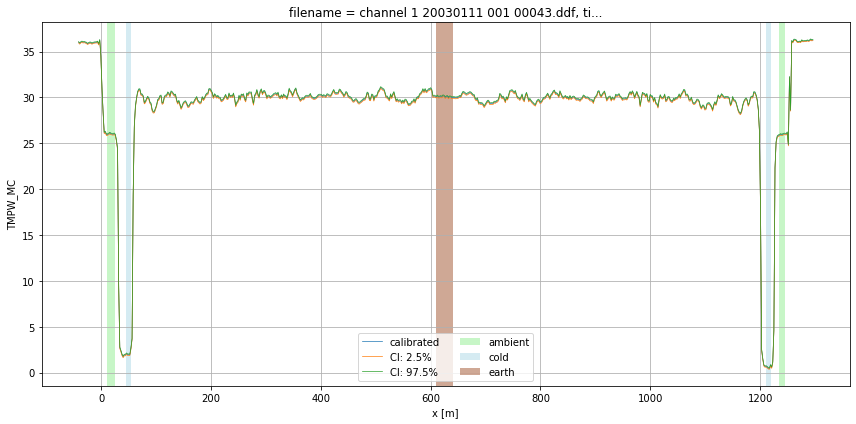

In [14]:
# Check the calibrated temperatures
# plot temp and confidence intervals last timestep
ds1 = ds.isel(time=-1)  # take only the last timestep
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ds1.TMPW.plot(ax=ax, linewidth=0.7, label="calibrated")
ds1.TMPW_MC.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%', ax=ax)
ds1.TMPW_MC.isel(CI=2).plot(linewidth=0.7, label='CI: 97.5%', ax=ax)

for name, sect in sections_verif.items():
    if name == "ambient":
        c = "LightGreen"
    elif name == "cold":
        c = "LightBlue"
    elif name == "earth":
        c = "Sienna"
    else:
        c = "gray"
    lbl = name
    for s in sect:
        ax.axvspan(s.start, s.stop, facecolor=c, alpha=0.5, label=lbl)
        lbl = None

ax.legend(loc="best", ncol=2)
ax.grid(b=True)
fig.tight_layout()
if savefig:
    fig.savefig(os.path.join(
        figdir, f"temp_ci_last_timestep_{channel}_{calibstr}.png"), dpi=150)

### [Standard deviation of calibrated temperature](#top)<a id="4.2"></a>

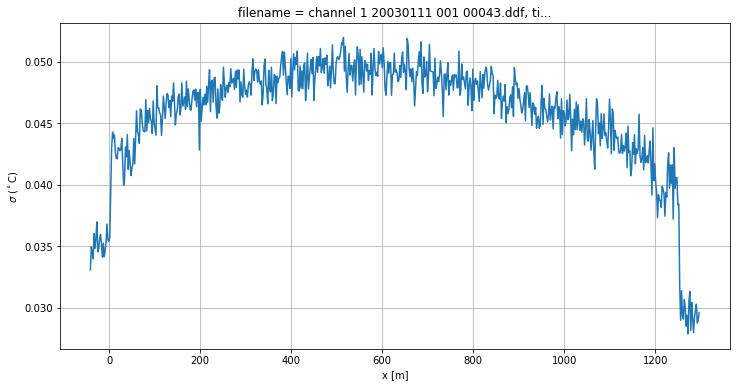

In [11]:
# Plot st dev of TWMPW
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
(ds1.tmpw_mc_var**0.5).plot(ax=ax)
ax.set_ylabel('$\sigma$ ($^\circ$C)')
ax.grid(b=True)

### [Residuals per reference section](#top)<a id="4.3"></a>

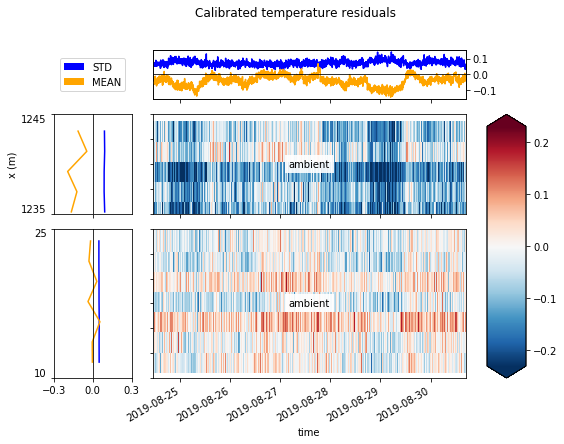

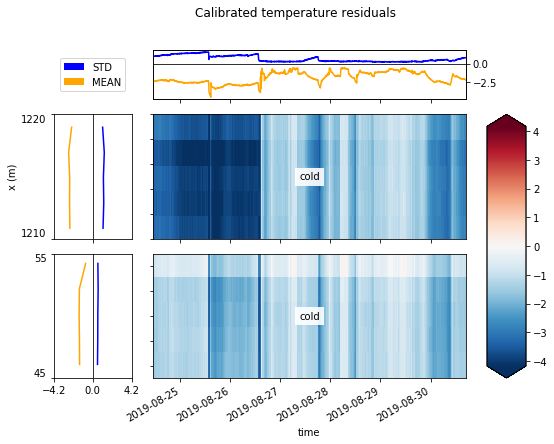

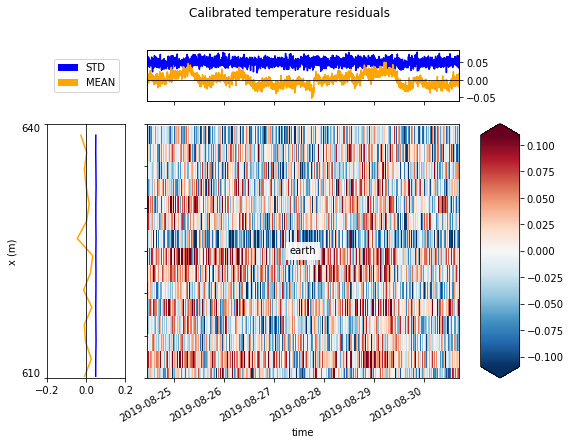

In [12]:
# 3. Residuals in reference sections
for name, sect in sections_verif.items():
    ds.sections = {name: sect}
    temp_resid_verif = ds.temperature_residuals('tmpw')
    try:
        fig = dtsplot.plot_residuals_reference_sections(
            temp_resid_verif, {name: sect}, title='Calibrated temperature residuals')
    except:
        continue
    if savefig:
        fig.savefig(
            os.path.join(
                figdir, f"temp_residuals_{name}_after_calib_{channel}_{calibstr}.png"),
            dpi=150, bbox_inches="tight")

### [Mean DTS temperature in calibration bath vs. probe temperature](#top)<a id="4.4"></a>

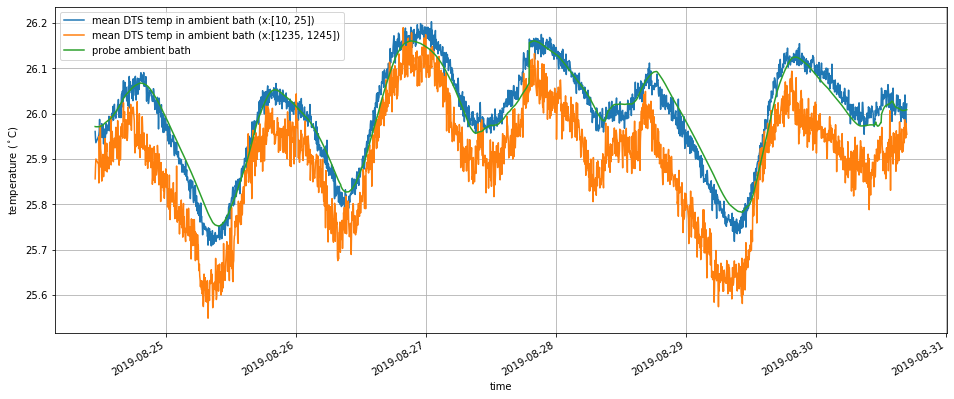

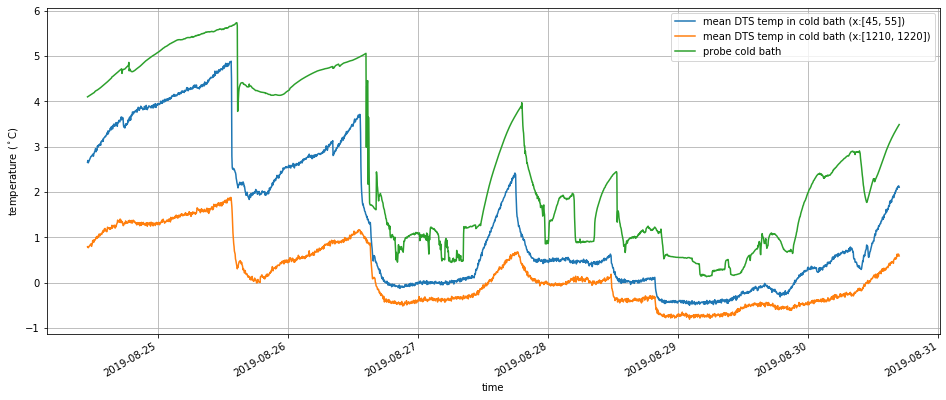

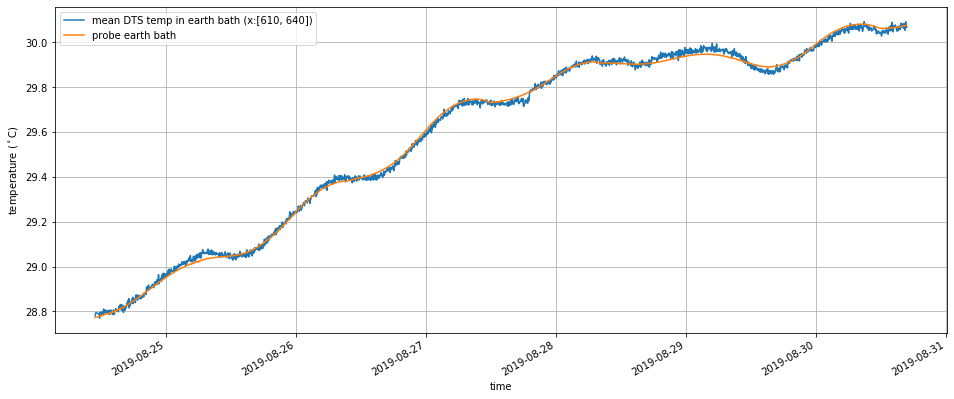

In [13]:
# 4. Mean DTS temp vs. probe temp
for name, sect in sections_verif.items():

    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    for s in sect:
        dsx = ds.sel(x=s).mean(dim="x")
        dsx.tmpw.plot.line(ax=ax, label=(f"mean DTS temp in {name} bath "
                                         f"(x:[{s.start}, {s.stop}])"))

    probe = ds.get(name)
    probe.plot.line(ax=ax, label=f"probe {name} bath")

    ax.legend(loc="best")
    ax.set_ylabel("temperature ($^\circ$C)")
    ax.grid(b=True)
    fig.savefig(f"./fig/bath_{name}_temp_over_time_calib_{channel}_{calibstr}.png",
                bbox_inches="tight", dpi=150)